# Lab 4: Advanced Neural Nets

   1.  Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір). 
   
Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  


   2. Проведіть експерименти з моделями бібліотеки HF Transformers (https://huggingface.co/) за допомогою (наприклад) Pipeline модуля


   3. Завдання щодо генерації або стилізації зображень (на вибір)
   
Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE).


In [1]:
#1 Переклад тексту на базі рекурентних мереж

In [20]:
data_path = "ukr.txt"

In [22]:
num_samples = 5000

input_texts = []
output_texts = []
input_characters = set()
output_characters = set()

with open(data_path, 'r', encoding = 'utf-8') as f:
    lines = f.read().split('\n')
for line in lines[:min(num_samples,len(lines)-1)]:
    input_text, output_text, _ = line.split('\t')
    
    # We use 'tab' as the 'start sequence' character
    # for the targets, and '\n' as the 'end sequence' character.
    
    output_text = '\t' + output_text + '\n'
    input_texts.append(input_text)
    output_texts.append(output_text)

    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in output_text:
        if char not in output_characters:
            output_characters.add(char)

In [23]:
input_characters = sorted(list(input_characters))
output_characters = sorted(list(output_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(output_characters)
max_encoder_seq_length = max([len(text) for text in input_texts])
max_decoder_seq_length = max([len(text) for text in output_texts])

In [26]:
print("input_characters len: ",len(input_characters),"\noutput_characters len: ", len(output_characters) )

input_characters len:  69 
output_characters len:  88


In [27]:
input_token_index = dict(
    [(char,i) for i,char in enumerate(input_characters)])

output_token_index = dict(
    [(char,i) for i,char in enumerate(output_characters)])

In [30]:
import numpy as np

encoder_input_data = np.zeros(
    (len(input_texts),max_encoder_seq_length,num_encoder_tokens),dtype = 'float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length , num_decoder_tokens), dtype = 'float32')
decoder_output_data = np.zeros(
    (len(input_texts), max_decoder_seq_length,num_decoder_tokens) , dtype = 'float32')

In [33]:
import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

In [36]:
batch_size = 64
epochs = 100
latent_dim = 256

In [37]:
for i,(input_text,output_text) in enumerate(zip(input_texts,output_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i,t,input_token_index[char]] = 1.
    encoder_input_data[i,t+1:,input_token_index[' ']] = 1.
    
    for t, char in enumerate(output_text):
        # decoder_output_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i,t,output_token_index[char]] = 1.
        if t>0:
            # decoder_output_data will be ahead by one timestep
            # and will not include the start character
            decoder_output_data[i,t-1,output_token_index[char]] = 1.
    decoder_input_data[i,t+1:, output_token_index[' ']] = 1.
    decoder_output_data[i , t: , output_token_index[' ']] = 1.

In [38]:
# define an input sequence and process it:
encoder_inputs = Input(shape = (None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state= True)
encoder_outputs,state_h,state_c = encoder(encoder_inputs)
# we discard 'encoder_outputs' and only keep the states.
encoder_states = [state_h,state_c]

In [39]:
# set up the decoder, using encoder_states as initial states:
decoder_inputs= Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim,return_sequences = True, return_state = True)


# We set our decoder to return full output sequences, and to return internal states as well but we don’t use this internal states in the training model,  
#  but we will use them in inference.

decoder_outputs, _ ,_ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens,activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [41]:
# Define the model that will turn
# 'encoder_input_data' & 'decoder_input_data' into 'decoder_output_data'
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)

#Run training:
model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.fit([encoder_input_data,decoder_input_data], decoder_output_data,
         batch_size=batch_size,
         epochs = epochs,
         validation_split=0.2)

Epoch 1/100
63/63 [==============================] - 11s 126ms/step - loss: 1.4778 - accuracy: 0.7056 - val_loss: 1.2689 - val_accuracy: 0.6968
Epoch 2/100
63/63 [==============================] - 7s 116ms/step - loss: 1.1547 - accuracy: 0.7205 - val_loss: 1.1494 - val_accuracy: 0.7016
Epoch 3/100
63/63 [==============================] - 7s 114ms/step - loss: 1.0526 - accuracy: 0.7304 - val_loss: 1.0639 - val_accuracy: 0.7125
Epoch 4/100
63/63 [==============================] - 7s 114ms/step - loss: 0.9759 - accuracy: 0.7427 - val_loss: 1.0207 - val_accuracy: 0.7209
Epoch 5/100
63/63 [==============================] - 7s 111ms/step - loss: 0.9203 - accuracy: 0.7546 - val_loss: 0.9649 - val_accuracy: 0.7303
Epoch 6/100
63/63 [==============================] - 7s 114ms/step - loss: 0.8682 - accuracy: 0.7662 - val_loss: 0.9361 - val_accuracy: 0.7485
Epoch 7/100
63/63 [==============================] - 7s 115ms/step - loss: 0.8163 - accuracy: 0.7766 - val_loss: 0.8574 - val_accuracy: 0.761

In [42]:
# define sampling models:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape = (latent_dim,))
decoder_state_input_c = Input(shape = (latent_dim,))
decoder_input_states = [decoder_state_input_h,decoder_state_input_c]

decoder_outputs,state_h,state_c = decoder_lstm(decoder_inputs, initial_state=decoder_input_states)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs]+decoder_input_states,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict(
    (i,char) for char,i in input_token_index.items())
reverse_output_char_index = dict(
    (i,char) for char,i in output_token_index.items())

def decode_sequence(input_seq):
    states_value= encoder_model.predict(input_seq)
    output_seq = np.zeros((1,1,num_decoder_tokens))
    output_seq[0,0,output_token_index['\t']] = 1
    
    stop_condition = False
    decoded_sentences = ''
    while not stop_condition:
        output_tokens,h,c = decoder_model.predict(
            [output_seq]+ states_value)
        
        sampled_token_index = np.argmax(output_tokens[0,-1, :])
        sampled_char = reverse_output_char_index[sampled_token_index]
        decoded_sentences += sampled_char

        if(sampled_char == '\n' or len(decoded_sentences) > max_decoder_seq_length):
            stop_condition = True
        
        #update the target sequence (of length 1):
        output_seq = np.zeros((1,1,num_decoder_tokens))
        output_seq[0,0,sampled_token_index] = 1
        
        states_value = [h,c]
    return decoded_sentences

for seq_index in range(20):
    # take one sequence for trying out decoding:
    input_seq = encoder_input_data[seq_index:seq_index+1]
    decoded_sentences = decode_sequence(input_seq)
    print('ProjectGurukul Project: English to Ukraine Translation ')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:' , decoded_sentences)

1/1 [==============================] - 0s 19ms/step
ProjectGurukul Project: English to Ukraine Translation 
Input sentence: Go.
Decoded sentence: Йди геть!

1/1 [==============================] - 0s 21ms/step
ProjectGurukul Project: English to Ukraine Translation 
Input sentence: Hi.
Decoded sentence: Привіт!

1/1 [==============================] - 0s 20ms/step
ProjectGurukul Project: English to Ukraine Translation 
Input sentence: Hi.
Decoded sentence: Привіт!

1/1 [==============================] - 0s 21ms/step
ProjectGurukul Project: English to Ukraine Translation 
Input sentence: Hi.
Decoded sentence: Привіт!

1/1 [==============================] - 0s 20ms/step
ProjectGurukul Project: English to Ukraine Translation 
Input sentence: Run!
Decoded sentence: Оіжі!

1/1 [==============================] - 0s 21ms/step
ProjectGurukul Project: English to Ukraine Translation 
Input sentence: Run!
Decoded sentence: Оіжі!

1/1 [==============================] - 0s 20ms/step
ProjectGurukul Pro

In [6]:
#2
from transformers import pipeline

pipe = pipeline("fill-mask", model="ukr-models/xlm-roberta-base-uk")

config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/854k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [7]:
pipe("Тарас Шевченко – великий український <mask>.")

[{'score': 0.8986253142356873,
  'token': 15258,
  'token_str': 'поет',
  'sequence': 'Тарас Шевченко – великий український поет.'},
 {'score': 0.023822089657187462,
  'token': 22255,
  'token_str': 'письменник',
  'sequence': 'Тарас Шевченко – великий український письменник.'},
 {'score': 0.02075241133570671,
  'token': 24036,
  'token_str': 'композитор',
  'sequence': 'Тарас Шевченко – великий український композитор.'},
 {'score': 0.020646600052714348,
  'token': 16875,
  'token_str': 'художник',
  'sequence': 'Тарас Шевченко – великий український художник.'},
 {'score': 0.006398239638656378,
  'token': 22274,
  'token_str': 'філософ',
  'sequence': 'Тарас Шевченко – великий український філософ.'}]

In [1]:
#3 Генерація зображень Conv GAN

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Flatten, Reshape

from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

In [10]:
(x_train, y_train), (_, _) = cifar100.load_data()
print(x_train.shape)

(50000, 32, 32, 3)


In [11]:
num_classes = np.unique(y_train).shape[0]

In [5]:
num_classes

100

In [17]:
filter = np.where(y_train == 7)
x_train = x_train[filter[0]]

In [18]:
x_train.shape

(500, 32, 32, 3)

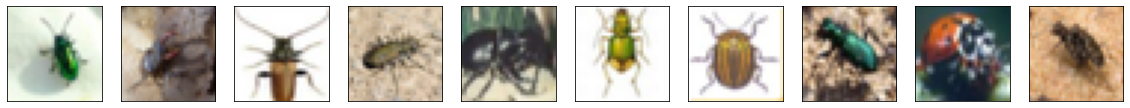

In [19]:
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [20]:
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalization [-1, 1]
x_train = np.clip(x_train, -1, 1)

In [21]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)

In [22]:
def build_discriminator():
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model

latent_dim = 100

def build_generator():
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model   

def build_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [23]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise)
    # scale from [-1,1] to [0,1]
    generated_images = (generated_images + 1) / 2.0
    
    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [24]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        print(ep)
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
             # Generate fake CIFAR images
            generated_images = generator.predict(noise, verbose=0)
            
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss, _ = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 5  == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

0
epoch:  0
1/1 [==============================] - 0s 29ms/step


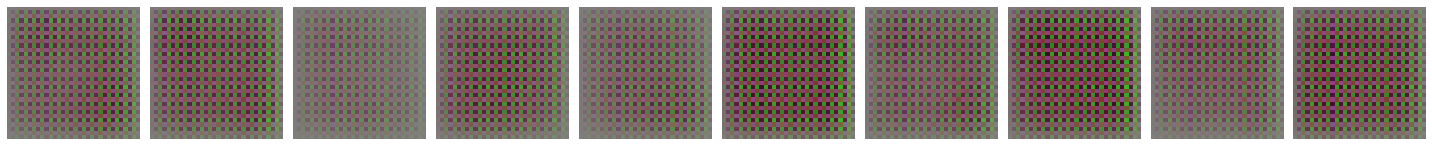

1
2
3
4
5
epoch:  5
1/1 [==============================] - 0s 38ms/step


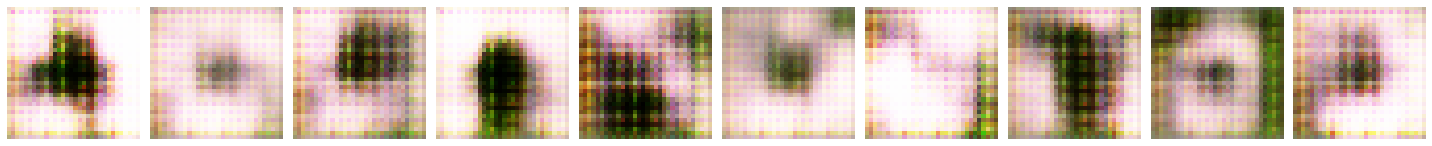

6
7
8
9
10
epoch:  10
1/1 [==============================] - 0s 47ms/step


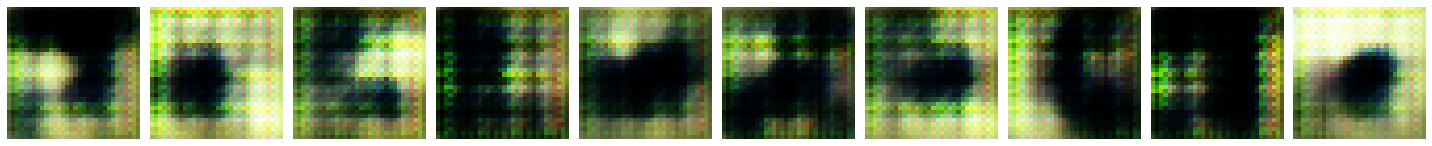

11
12
13
14
15
epoch:  15
1/1 [==============================] - 0s 35ms/step


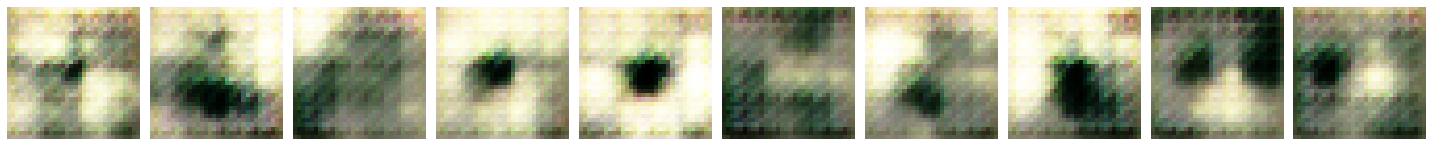

16
17
18
19
20
epoch:  20
1/1 [==============================] - 0s 34ms/step


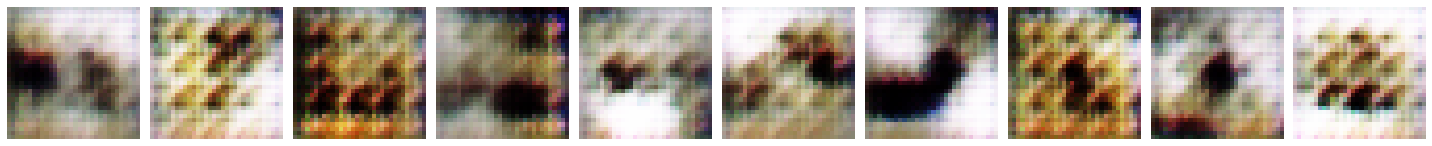

21
22
23
24
25
epoch:  25
1/1 [==============================] - 0s 34ms/step


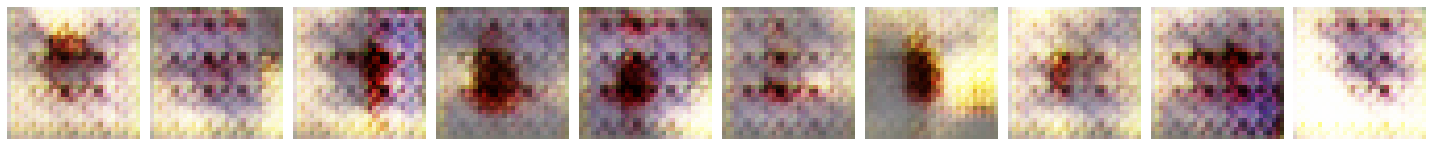

26
27
28
29
30
epoch:  30
1/1 [==============================] - 0s 33ms/step


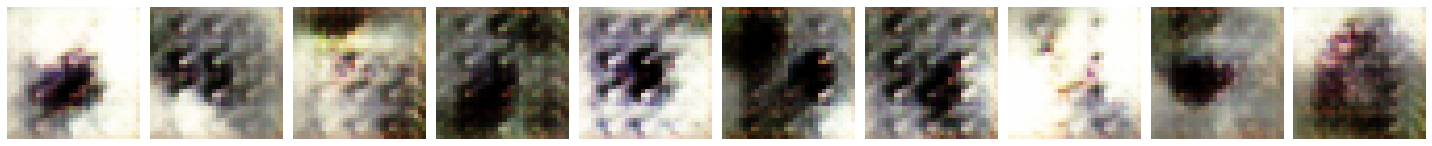

31
32
33
34
35
epoch:  35
1/1 [==============================] - 0s 33ms/step


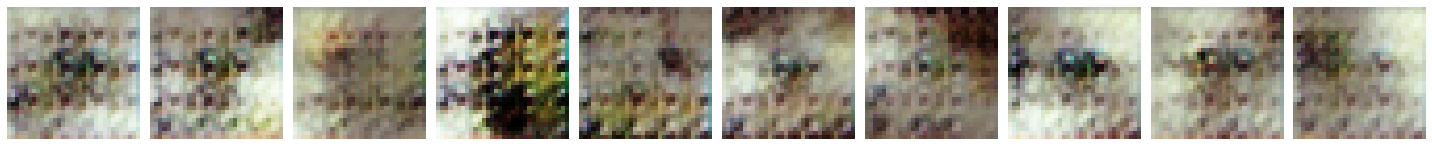

36
37
38
39
40
epoch:  40
1/1 [==============================] - 0s 36ms/step


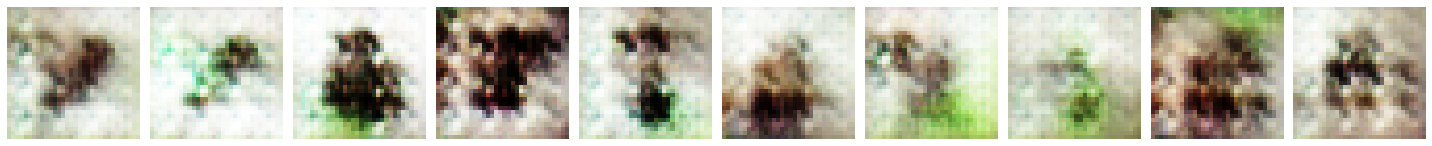

41
42
43
44
45
epoch:  45
1/1 [==============================] - 0s 37ms/step


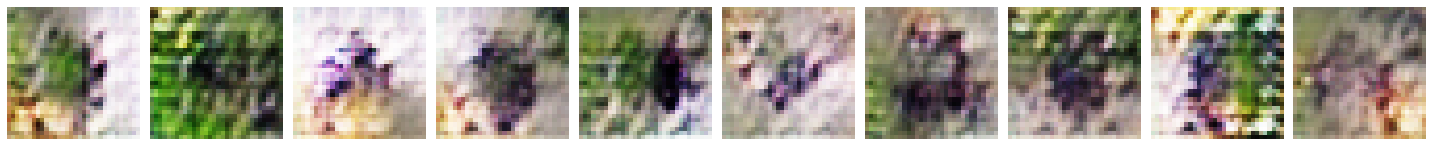

46
47
48
49
50
epoch:  50
1/1 [==============================] - 0s 35ms/step


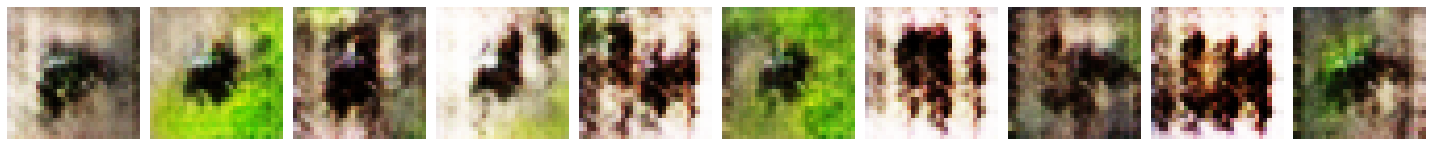

51
52
53
54
55
epoch:  55
1/1 [==============================] - 0s 32ms/step


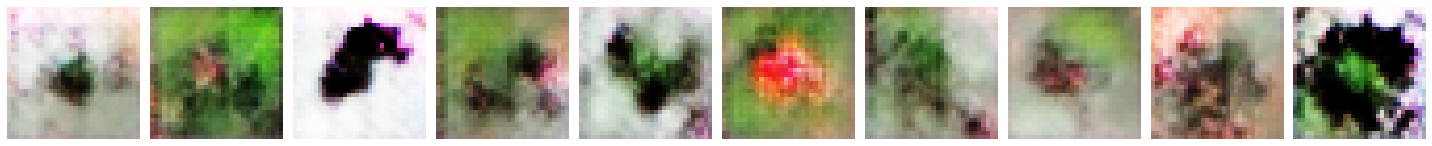

56
57
58
59
60
epoch:  60
1/1 [==============================] - 0s 36ms/step


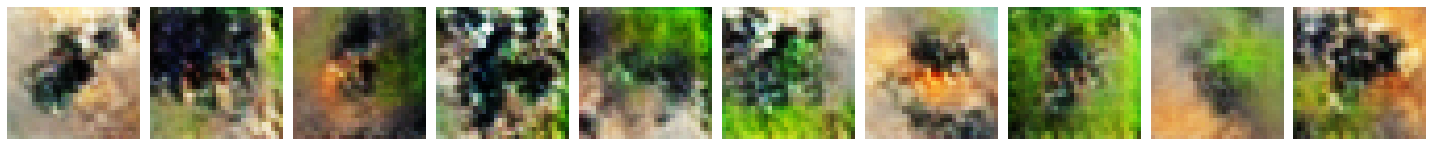

61
62
63
64
65
epoch:  65
1/1 [==============================] - 0s 39ms/step


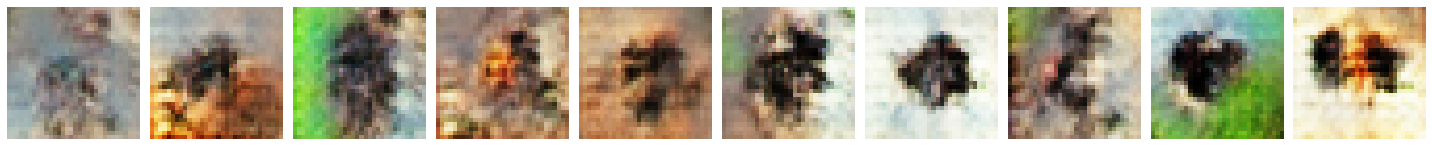

66
67
68
69
70
epoch:  70
1/1 [==============================] - 0s 31ms/step


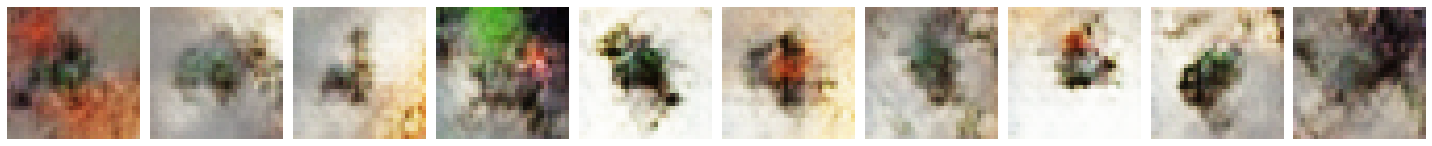

71
72
73
74
75
epoch:  75
1/1 [==============================] - 0s 34ms/step


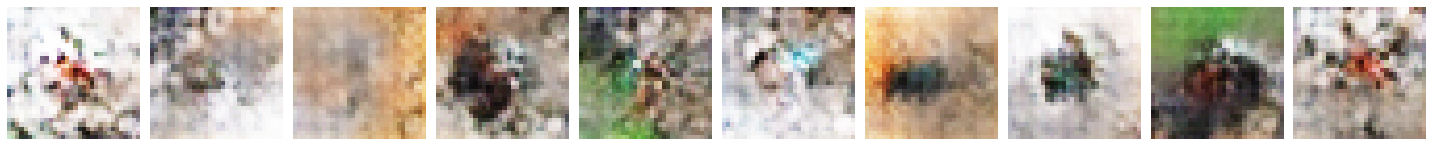

76
77
78
79
80
epoch:  80
1/1 [==============================] - 0s 42ms/step


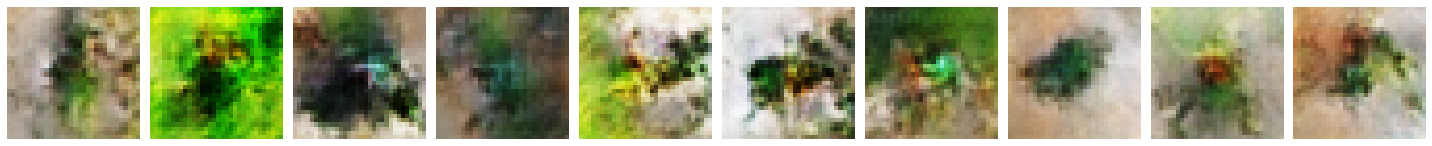

81
82
83
84
85
epoch:  85
1/1 [==============================] - 0s 38ms/step


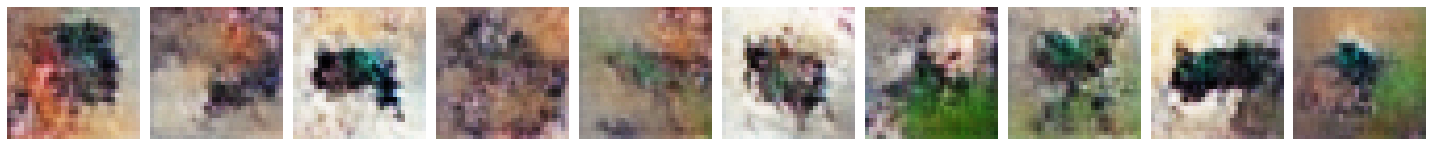

86
87
88
89
90
epoch:  90
1/1 [==============================] - 0s 40ms/step


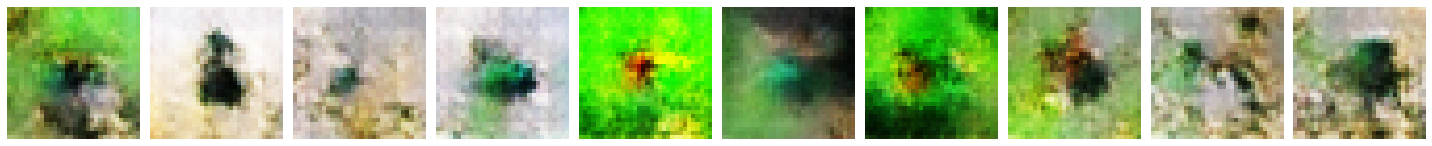

91
92
93
94
95
epoch:  95
1/1 [==============================] - 0s 32ms/step


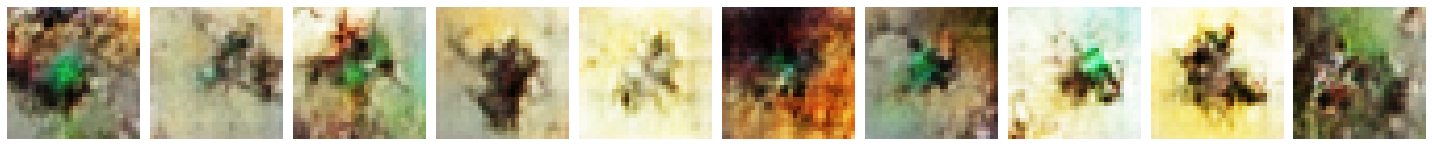

96
97
98
99
100
epoch:  100
1/1 [==============================] - 0s 33ms/step


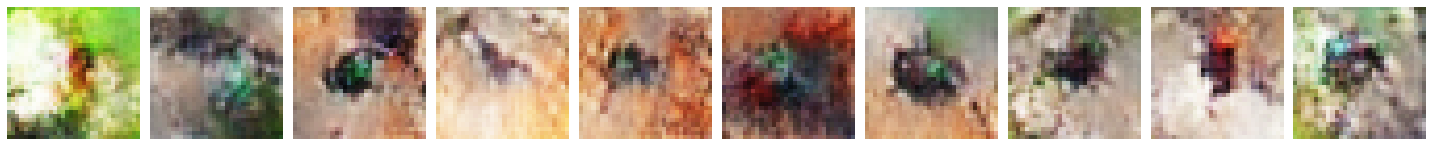

101
102
103
104
105
epoch:  105
1/1 [==============================] - 0s 33ms/step


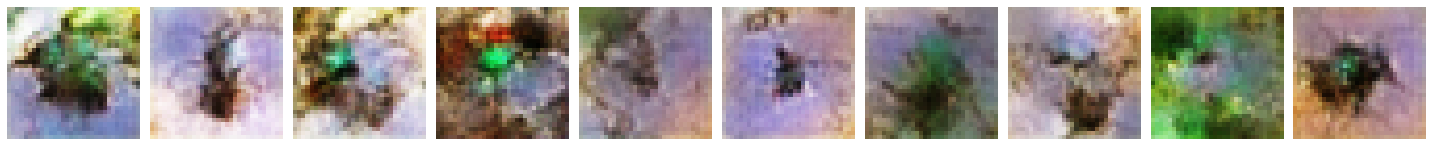

106
107
108
109
110
epoch:  110
1/1 [==============================] - 0s 33ms/step


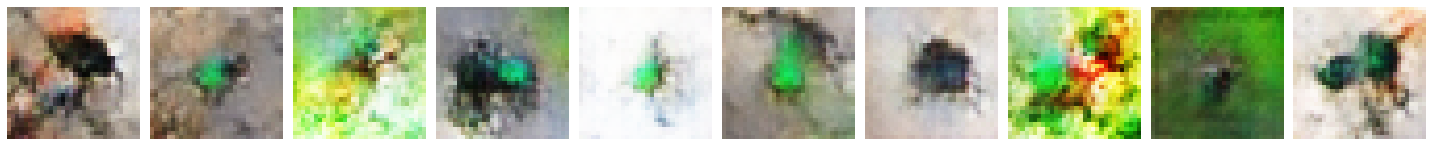

111
112
113
114
115
epoch:  115
1/1 [==============================] - 0s 34ms/step


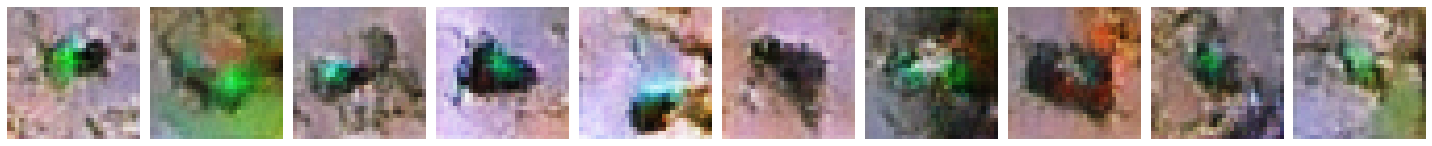

116
117
118
119
120
epoch:  120
1/1 [==============================] - 0s 32ms/step


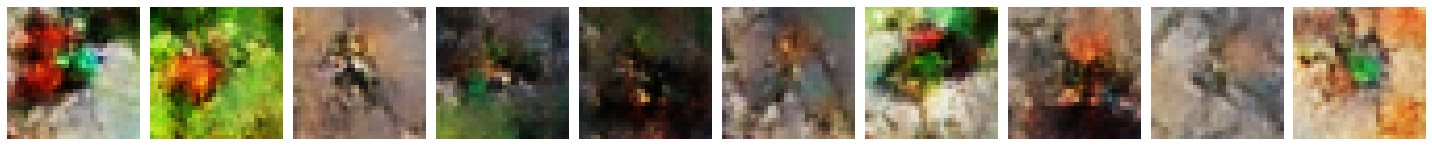

121
122
123
124
125
epoch:  125
1/1 [==============================] - 0s 26ms/step


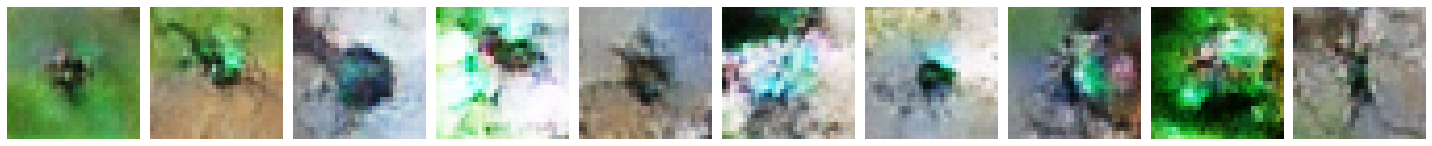

126
127
128
129
130
epoch:  130
1/1 [==============================] - 0s 34ms/step


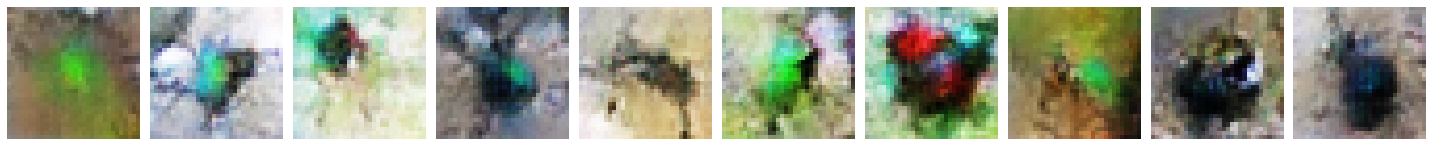

131
132
133
134
135
epoch:  135
1/1 [==============================] - 0s 30ms/step


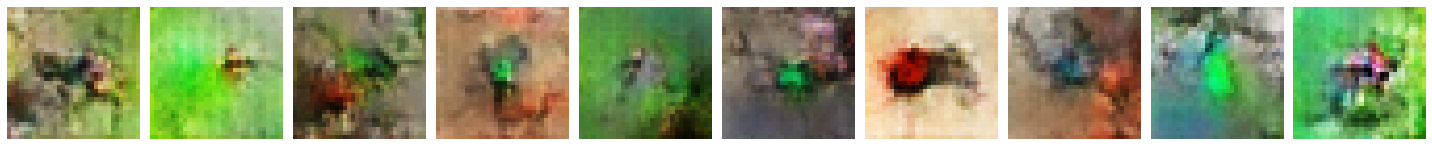

136
137
138
139
140
epoch:  140
1/1 [==============================] - 0s 36ms/step


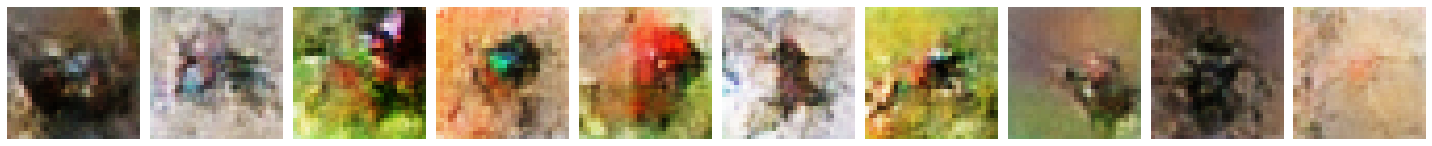

141
142
143
144
145
epoch:  145
1/1 [==============================] - 0s 29ms/step


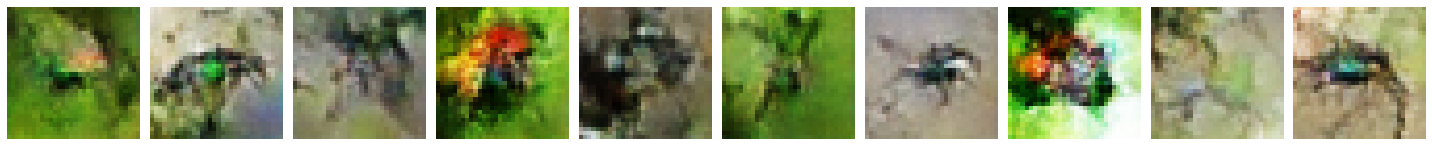

146
147
148
149
150
epoch:  150
1/1 [==============================] - 0s 28ms/step


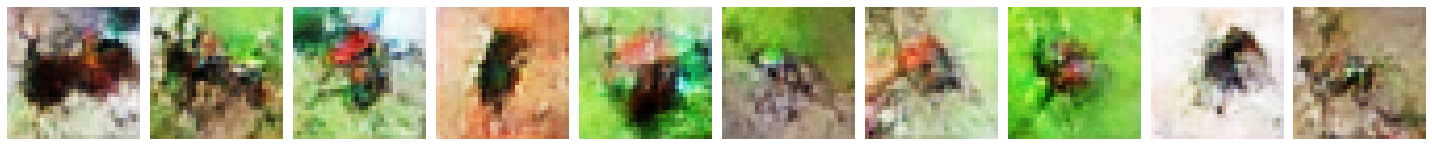

In [26]:
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)


epochs = 150
batch_size = 8
train_model(epochs, batch_size)